# Year 2

## Importing modules

In [1]:
#standard libs
from math import sqrt
import random
import os

#default data science libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#modules for data preprocessing
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.model_selection import RandomizedSearchCV

#classification models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

#evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier




In [2]:
from scipy.io import arff

## loading data

In [3]:
data = pd.read_excel('data/2year.xlsx')
data['B'] = (data['B'].index > 9772).astype(int)

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,B
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,0
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,0
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,0
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,0
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,0


# Data preprocessing

In [5]:
def set_new_headers(df):
    cols = ['X' + str(i+1) for i in range(len(df.columns)-1)]
    cols.append('Y')
    df.columns = cols

imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
mean_imputed_df = pd.DataFrame(imputer.fit_transform(data))
set_new_headers(mean_imputed_df)

data_imp = pd.DataFrame()



In [6]:
Y = mean_imputed_df['Y'].values
mean_imputed_df.drop('Y', axis=1, inplace=True)
X = mean_imputed_df.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=10)

In [8]:
#cross validation
nfolds = 10
nclass = 2
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

cross_val = StratifiedKFold(nfolds)

# Creating model objects
## Tuning model hyperparameters

# Second level

In [9]:
def show_feature_importance(model, features, model_name):
    plt.figure(figsize=(12,8))
    results=pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results=results.sort_values('importance', ascending=False)
    results.head(70)
#     results.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
#                      color = 'red', edgecolor = 'k', title = 'Feature Importances of ' + model_name)
    return results

In [10]:
ntrain=X_train.shape[0]
ntest = X_test.shape[0]
nclass = 2
SEED = 42
NFOLDS = 10
print(ntrain, ntest)
kf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
labels = ['Normal','Bankruptcy']

7121 3052


In [11]:
def BuildModel(best_alg, X_train, y_train, X_test, kf, ntrain, ntest, nclass, NfOLDS):
    Xr_train = np.zeros((ntrain, nclass))
    Xr_test = np.zeros((ntest, nclass))
    tr_ind = np.arange(ntrain)
    smote = SMOTE(sampling_strategy = 0.09, random_state=32)
    for i, (ttrain, ttest) in enumerate(kf.split(tr_ind)):
        clf = best_alg
        X=X_train[ttrain]
        y=y_train[ttrain]
        X_train_sm, y_train_sm= smote.fit_sample(X, y)
        clf.fit(X_train_sm, y_train_sm)
        sc = clf.score(X_train[ttest], y_train[ttest])
        print(i, 'accuracy', sc)
        Xr_train[ttest] = clf.predict_proba(X_train[ttest])
        Xr_test += clf.predict_proba(X_test)/NFOLDS
    
    return Xr_train, Xr_test


def BuildModelNot(best_alg, X_train, y_train, X_test, kf, ntrain, ntest, nclass, NfOLDS):
    Xr_train = np.zeros((ntrain, nclass))
    Xr_test = np.zeros((ntest, nclass))
    tr_ind = np.arange(ntrain)
    smote = SMOTE(sampling_strategy= 0.09, random_state=32)
    for i, (ttrain, ttest) in enumerate(kf.split(tr_ind)):
        clf = best_alg
        X=X_train[ttrain]
        y=y_train[ttrain]
        X_train_sm, y_train_sm= smote.fit_sample(X, y)
        clf.fit(X_train_sm, y_train_sm)
        sc = clf.score(X_train[test], y_train[ttest])
        print(i, 'accuracy', sc)
        Xr_train[ttest] = clf.predict_proba(X_train[ttest])
        Xr_test += clf.predict_proba(X_test, validate_features=False)/NFOLDS
    
    return Xr_train, Xr_test

In [12]:
def show_accuracy(Xr, y, labels, best, nclass):
    pred=[]
    for x in Xr:
        if x > best:
            pred.append(1)
        else:
            pred.append(0)
    print(classification_report(y,pred, target_names=labels, digits=4))
    print(confusion_matrix(y, pred, labels=range(nclass)))

In [13]:
def show_auc(y_train_set, pred_train_set):
    thresholds = np.linspace(0.01, 0.5, 1000)
    f1_sc = np.array([f1_score(y_train_set, pred_train_set[:,1] > thr) for thr in thresholds])
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, f1_sc, linewidth=4)
    plt.ylabel("F1 score", fontsize=18)
    plt.xlabel("Threshold", fontsize=18)
    
    best_model_f1 = thresholds[f1_sc.argmax()]
    
    return best_model_f1

In [14]:
X_train

array([[ 6.2971e-02,  5.1854e-01,  1.0594e-02, ...,  1.1576e+02,
         3.1531e+00,  1.8254e+00],
       [ 4.4568e-04,  8.7631e-01,  3.5080e-01, ...,  1.1420e+02,
         3.1962e+00,  6.6508e+00],
       [ 1.1732e-01,  3.3079e-01,  5.7334e-01, ...,  2.5183e+01,
         1.4494e+01,  9.3508e+00],
       ...,
       [-5.3670e-01,  7.8497e-02,  2.6824e-01, ...,  2.4876e+01,
         1.4673e+01,  1.1851e+00],
       [ 4.6735e-01,  3.9807e-01,  1.4838e-02, ...,  4.3617e+01,
         8.3683e+00,  2.5717e+00],
       [ 8.3040e-02,  5.4857e-01,  2.4094e-01, ...,  8.4371e+01,
         4.3261e+00,  5.8015e+00]])

## Logistic regression

In [15]:
lr_best = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
pred_train, pred_test=BuildModel(lr_best, X_train, y_train, X_test,kf, ntrain, ntest, nclass, NFOLDS)

C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


0 accuracy 0.9495091164095372


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


1 accuracy 0.9536516853932584


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


2 accuracy 0.9676966292134831


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


3 accuracy 0.9747191011235955


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


4 accuracy 0.9578651685393258


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


5 accuracy 0.9452247191011236


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6 accuracy 0.9438202247191011


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


7 accuracy 0.952247191011236


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


8 accuracy 0.9564606741573034
9 accuracy 0.9564606741573034


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


0.1672727272727273
0.12686868686868688


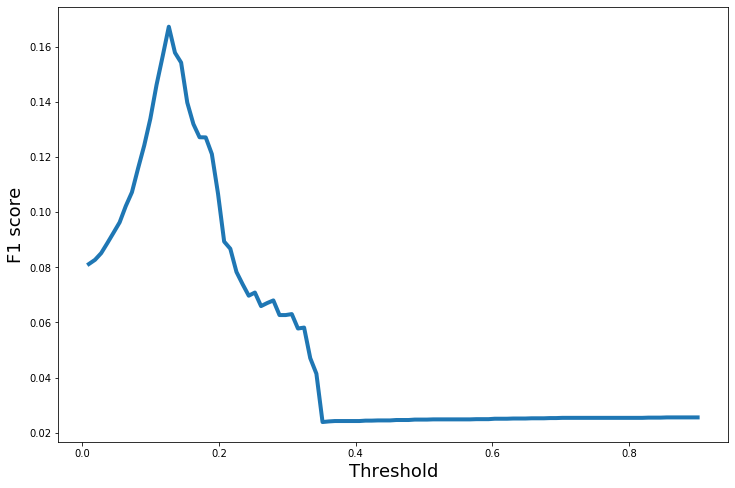

In [16]:
thresholds = np.linspace(0.01, 0.9, 100)
f1_sc = np.array([f1_score(y_train,pred_train[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_lr = thresholds[f1_sc.argmax()]
print(f1_sc.max())
print(best_lr)

In [17]:
show_accuracy(pred_train[:,1],y_train, labels, best_lr, nclass)

              precision    recall  f1-score   support

      Normal     0.9680    0.8954    0.9303      6827
  Bankruptcy     0.1141    0.3129    0.1673       294

    accuracy                         0.8714      7121
   macro avg     0.5411    0.6042    0.5488      7121
weighted avg     0.9328    0.8714    0.8988      7121

[[6113  714]
 [ 202   92]]


In [18]:
show_accuracy(pred_test[:,1],y_test, labels, best_lr, nclass)

              precision    recall  f1-score   support

      Normal     0.9702    0.8948    0.9310      2946
  Bankruptcy     0.0746    0.2358    0.1134       106

    accuracy                         0.8719      3052
   macro avg     0.5224    0.5653    0.5222      3052
weighted avg     0.9391    0.8719    0.9026      3052

[[2636  310]
 [  81   25]]


## Decision tree

In [19]:
dt_best = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=150,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
pred_train_dt, pred_test_dt=BuildModel(dt_best, X_train, y_train, X_test,kf, ntrain, ntest, nclass, NFOLDS)

0 accuracy 0.9565217391304348
1 accuracy 0.9480337078651685
2 accuracy 0.9606741573033708
3 accuracy 0.9719101123595506
4 accuracy 0.9550561797752809
5 accuracy 0.9536516853932584
6 accuracy 0.9452247191011236
7 accuracy 0.9410112359550562
8 accuracy 0.9480337078651685
9 accuracy 0.949438202247191


0.43316412859560066
0.29707070707070704


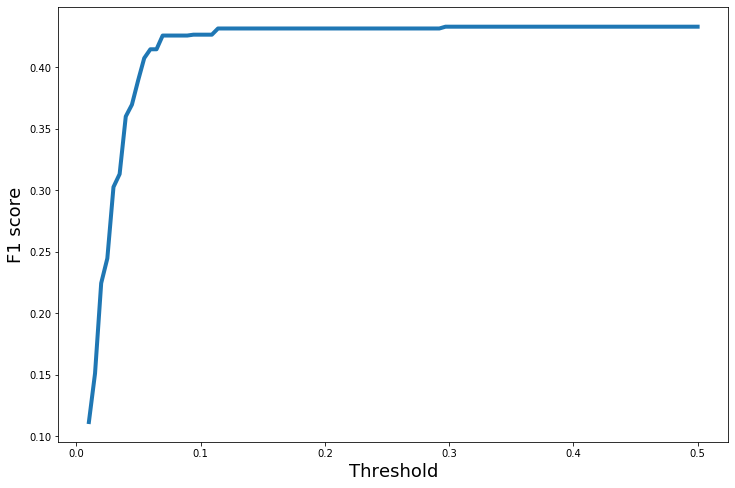

In [20]:
thresholds = np.linspace(0.01, 0.5, 100)
f1_sc_dt = np.array([f1_score(y_train,pred_train_dt[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc_dt, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_dt_f1 = thresholds[f1_sc_dt.argmax()]
print(f1_sc_dt.max())
print(best_dt_f1)

In [21]:
show_accuracy(pred_train_dt[:,1],y_train, labels, best_dt_f1, nclass)

              precision    recall  f1-score   support

      Normal     0.9757    0.9752    0.9755      6827
  Bankruptcy     0.4310    0.4354    0.4332       294

    accuracy                         0.9530      7121
   macro avg     0.7033    0.7053    0.7043      7121
weighted avg     0.9532    0.9530    0.9531      7121

[[6658  169]
 [ 166  128]]


In [22]:
show_accuracy(pred_test_dt[:,1],y_test, labels, best_dt_f1, nclass)

              precision    recall  f1-score   support

      Normal     0.9842    0.9756    0.9799      2946
  Bankruptcy     0.4545    0.5660    0.5042       106

    accuracy                         0.9613      3052
   macro avg     0.7194    0.7708    0.7420      3052
weighted avg     0.9658    0.9613    0.9634      3052

[[2874   72]
 [  46   60]]


In [23]:
print(mean_imputed_df.columns[:-1])

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41',
       'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51',
       'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61',
       'X62', 'X63'],
      dtype='object')


In [24]:
show_feature_importance(dt_best, mean_imputed_df.columns, 'Decision tree')

,feature,importance
33,X34,0.173553
26,X27,0.142668
57,X58,0.068835
55,X56,0.063504
5,X6,0.038334
...,...,...
13,X14,0.000000
52,X53,0.000000
43,X44,0.000000
22,X23,0.000000


<Figure size 864x576 with 0 Axes>

## Random forest

In [25]:
rf_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features=64, max_leaf_nodes=25,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

pred_train_rf, pred_test_rf = BuildModel(rf_best, X_train, y_train, X_test,kf, ntrain, ntest, nclass, NFOLDS)

0 accuracy 0.9691444600280504
1 accuracy 0.9676966292134831
2 accuracy 0.9845505617977528
3 accuracy 0.9831460674157303
4 accuracy 0.9705056179775281
5 accuracy 0.9676966292134831
6 accuracy 0.9578651685393258
7 accuracy 0.9676966292134831
8 accuracy 0.9719101123595506
9 accuracy 0.976123595505618


f1 score of random forest:  0.511545293072824
0.20151515151515154


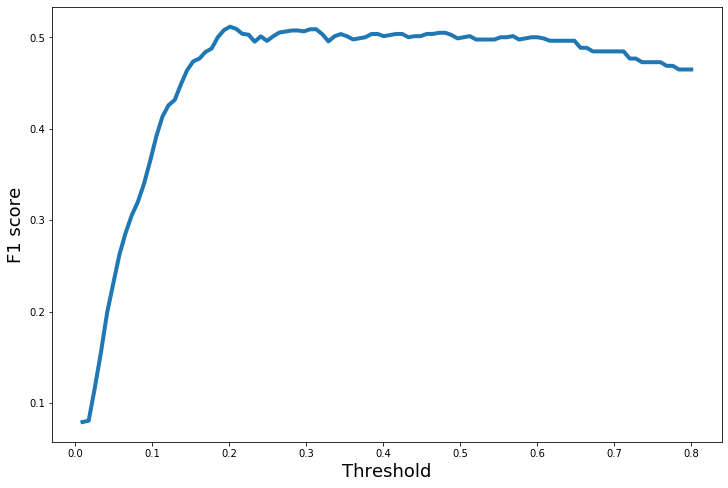

In [26]:
thresholds = np.linspace(0.01, 0.8, 100)
f1_sc_rf = np.array([f1_score(y_train,pred_train_rf[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc_rf, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_rf_f1 = thresholds[f1_sc_rf.argmax()]
print('f1 score of random forest: ', f1_sc_rf.max())
print(best_rf_f1)

In [27]:
show_accuracy(pred_train_rf[:,1],y_train, labels, best_rf_f1, nclass)

              precision    recall  f1-score   support

      Normal     0.9781    0.9817    0.9799      6827
  Bankruptcy     0.5353    0.4898    0.5115       294

    accuracy                         0.9614      7121
   macro avg     0.7567    0.7357    0.7457      7121
weighted avg     0.9598    0.9614    0.9606      7121

[[6702  125]
 [ 150  144]]


In [28]:
show_accuracy(pred_test_rf[:,1],y_test, labels, best_rf_f1, nclass)

              precision    recall  f1-score   support

      Normal     0.9807    0.9810    0.9808      2946
  Bankruptcy     0.4667    0.4623    0.4645       106

    accuracy                         0.9630      3052
   macro avg     0.7237    0.7216    0.7226      3052
weighted avg     0.9628    0.9630    0.9629      3052

[[2890   56]
 [  57   49]]


In [29]:
show_feature_importance(rf_best, mean_imputed_df.columns, 'Random forest')

,feature,importance
33,X34,0.283818
26,X27,0.188675
57,X58,0.092713
55,X56,0.056611
5,X6,0.042069
...,...,...
17,X18,0.000645
6,X7,0.000612
7,X8,0.000566
13,X14,0.000311


<Figure size 864x576 with 0 Axes>

## Xgboost

In [30]:
xgb_best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logitraw', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

pred_train_xgb, pred_test_xgb = BuildModel(xgb_best, X_train, y_train, X_test, kf, ntrain, ntest, nclass, NFOLDS)

0 accuracy 0.9691444600280504
1 accuracy 0.9747191011235955
2 accuracy 0.9831460674157303
3 accuracy 0.9887640449438202
4 accuracy 0.9705056179775281
5 accuracy 0.9705056179775281
6 accuracy 0.9620786516853933
7 accuracy 0.9676966292134831
8 accuracy 0.9705056179775281
9 accuracy 0.9845505617977528


0.5944700460829493


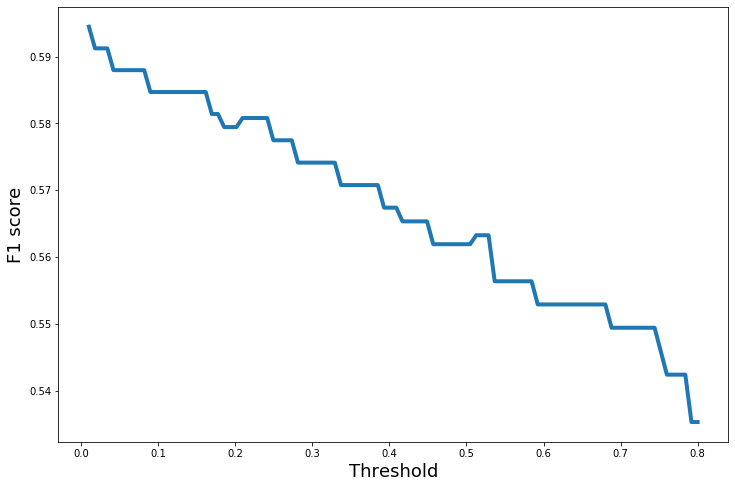

In [31]:
thresholds = np.linspace(0.01, 0.8, 100)
f1_sc_xgb = np.array([f1_score(y_train,pred_train_xgb[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc_xgb, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_thr_xgb = thresholds[f1_sc_xgb.argmax()]
print(f1_sc_xgb.max())

In [32]:
show_accuracy(pred_train_xgb[:,1],y_train, labels, best_thr_xgb, nclass)

              precision    recall  f1-score   support

      Normal     0.9764    0.9984    0.9873      6827
  Bankruptcy     0.9214    0.4388    0.5945       294

    accuracy                         0.9753      7121
   macro avg     0.9489    0.7186    0.7909      7121
weighted avg     0.9741    0.9753    0.9710      7121

[[6816   11]
 [ 165  129]]


In [33]:
show_accuracy(pred_test_xgb[:,1],y_test, labels, best_thr_xgb, nclass)

              precision    recall  f1-score   support

      Normal     0.9787    0.9976    0.9881      2946
  Bankruptcy     0.8571    0.3962    0.5419       106

    accuracy                         0.9767      3052
   macro avg     0.9179    0.6969    0.7650      3052
weighted avg     0.9745    0.9767    0.9726      3052

[[2939    7]
 [  64   42]]


In [34]:
show_feature_importance(xgb_best, mean_imputed_df.columns, 'XGboost')

,feature,importance
33,X34,0.070106
26,X27,0.035760
55,X56,0.033415
25,X26,0.028392
18,X19,0.028282
...,...,...
9,X10,0.006023
62,X63,0.004282
51,X52,0.002166
13,X14,0.000000


<Figure size 864x576 with 0 Axes>

C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0 accuracy 0.9453015427769986
1 accuracy 0.9564606741573034
2 accuracy 0.9676966292134831


C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


3 accuracy 0.9719101123595506
4 accuracy 0.9564606741573034
5 accuracy 0.9438202247191011


C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


6 accuracy 0.9438202247191011
7 accuracy 0.952247191011236
8 accuracy 0.9592696629213483


C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


9 accuracy 0.952247191011236
0.14893617021276595
              precision    recall  f1-score   support

      Normal     0.9672    0.8774    0.9201      6827
  Bankruptcy     0.0981    0.3095    0.1489       294

    accuracy                         0.8540      7121
   macro avg     0.5326    0.5935    0.5345      7121
weighted avg     0.9313    0.8540    0.8883      7121

[[5990  837]
 [ 203   91]]
              precision    recall  f1-score   support

      Normal     0.9703    0.8649    0.9146      2946
  Bankruptcy     0.0657    0.2642    0.1053       106

    accuracy                         0.8440      3052
   macro avg     0.5180    0.5645    0.5099      3052
weighted avg     0.9389    0.8440    0.8865      3052

[[2548  398]
 [  78   28]]


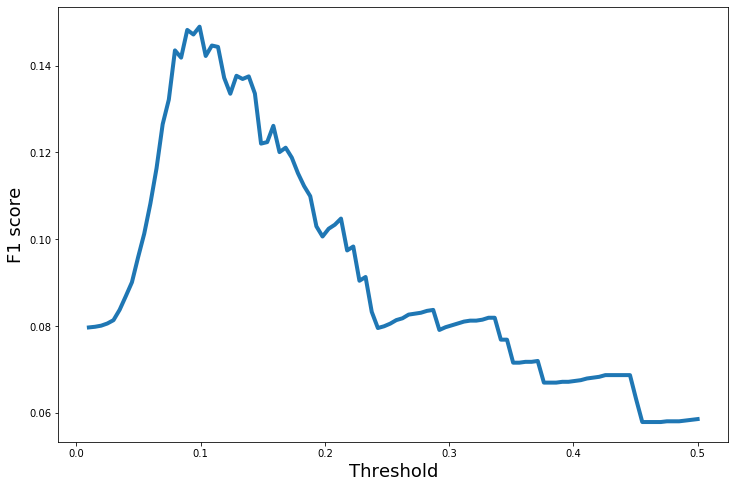

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()

lda.fit(X_train, y_train)
pred_train_lda, pred_test_lda = BuildModel(lda, X_train, y_train, X_test,kf, ntrain, ntest, nclass, NFOLDS)

thresholds = np.linspace(0.01, 0.5, 100)
f1_sc_lda = np.array([f1_score(y_train,pred_train_lda[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc_lda, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_thr_lda = thresholds[f1_sc_lda.argmax()]
print(f1_sc_lda.max())

show_accuracy(pred_train_lda[:,1],y_train, labels, best_thr_lda, nclass)

show_accuracy(pred_test_lda[:,1],y_test, labels, best_thr_lda, nclass)